<a href="https://colab.research.google.com/github/klebergoes/AD_Formula_1/blob/main/Projeto_Formula_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise de Performance dos Pilotos Ativos da Fórmula 1

##1.0. Importação pacotes e configuração para consumo de API

Importar os pacotes necessários para rodar o projeto

In [1]:
# Importação das bibliotecas

import pandas as pd

import matplotlib as mpl

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import kagglehub
from kagglehub import KaggleDatasetAdapter as kda

import os

import json

import warnings

Configurar o local para armazenar as credenciais de acesso ao Kaggle

In [2]:
# Credenciais para consumo da API Kaggle

kaggle_cred = {
    "username": "klebergoes",
    "key": "fc61c5a576e4685a33b7f42e91bc4525"
}

In [3]:
# Criando o diretório kaggle na instância do Colab para armazenar credenciais
# temporárias

kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

In [4]:
# Salvando o JSON das credenciais

kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
with open(kaggle_json_path, "w") as f:
    json.dump(kaggle_cred, f)

##2.0. Coleta de dados

Buscar dados na API da Kaggle para análise

In [5]:
# Nome do dataset no Kaggle

dataset = "muhammadehsan02/formula-1-world-championship-history-1950-2024"

In [6]:
# Nome dos arquivos dentro do dataset

driver_details_csv = "Driver_Details.csv"
race_results_csv = "Race_Results.csv"
race_schedule_csv = "Race_Schedule.csv"

In [7]:
# A função load_dataset será removida em versões futuras, usaremos o comando
# abaixo para suprimir o aviso de depreciação

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
# Carregando os arquivos para DataFrames

driver_details_df = kagglehub.load_dataset(
    kda.PANDAS,
    dataset,
    driver_details_csv
)

race_results_df = kagglehub.load_dataset(
    kda.PANDAS,
    dataset,
    race_results_csv
)

race_schedule_df = kagglehub.load_dataset(
    kda.PANDAS,
    dataset,
    race_schedule_csv
)

##3.0. Transformação dos dados

Preparando os dados para análise

In [9]:
# Junção entre os DataFrames driver_details_df e race_results_df para análise

merge_pilotos_corridas_df = race_results_df.merge(
    driver_details_df,
    on="driverId",
    how="left"
)

In [10]:
# Dos 20 pilotos escalados para a temporada de 2025, 16 possuem histórico de
# corrida, vamos realizar o filtro:

pilotos_temporada_2025_df = merge_pilotos_corridas_df[
    merge_pilotos_corridas_df["driverRef"].isin(
        [
            "hamilton", "max_verstappen", "alonso", "leclerc", "sainz",
            "russell", "ocon", "gasly", "norris", "bearman", "stroll",
            "hulkenberg", "lawson", "tsunoda", "piastri", "albon"
        ]
    )
]

In [11]:
# Renomeando as colunas "driverRef" para "Piloto" e "points" para "Pontos" para
# melhor visualização

pilotos_temporada_2025_df = pilotos_temporada_2025_df.rename(
    columns={
        "driverRef": "Piloto",
        "points": "Pontos"
    }
)

##4.0 Exploração dos dados

###4.1. Triagem dos pilotos

A análise será feita com base nos pilotos com maior índice de vitórias (aproveitamento), que é

a quantidade de corridas que o piloto participou dividida pela quantidade de vezes que ficou em

primeiro lugar

In [12]:
# Agrupando os dados por piloto e calculando o número de corridas e vitórias

triagem_pilotos_df = pilotos_temporada_2025_df[
    ["Piloto", "resultId", "positionOrder"]
].groupby(
    ["Piloto"]
).agg(
    {
    "resultId": lambda x: x.count(),
    "positionOrder": lambda x: (x == 1).sum()
    }
)

# Calculando o índice de vitórias (%)

triagem_pilotos_df["Indice_Vitorias_(%)"] = (
    triagem_pilotos_df["positionOrder"] / triagem_pilotos_df["resultId"]
)

# Renomeando as colunas para uma visualização mais clara

triagem_pilotos_df = triagem_pilotos_df.rename(
    columns={
    "resultId": "Nº_Corridas",
    "positionOrder": "Vitorias"
    }
)

# Convertendo o índice de vitórias para percentual e arredondando para 2 casas
# decimais

triagem_pilotos_df["Indice_Vitorias_(%)"] = (
    triagem_pilotos_df["Indice_Vitorias_(%)"] * 100
).round(2)

# Ordenando os pilotos pelo índice de vitórias de forma decrescente para
# evidenciar os maiores índices

triagem_pilotos_df = triagem_pilotos_df.sort_values(
    by="Indice_Vitorias_(%)",
    ascending=False
)

# Exibindo o DataFrame final

triagem_pilotos_df

,Nº_Corridas,Vitorias,Indice_Vitorias_(%)
Piloto,,,
max_verstappen,197,61,30.96
hamilton,344,104,30.23
alonso,392,32,8.16
leclerc,137,6,4.38
russell,116,2,1.72
sainz,196,3,1.53
norris,116,1,0.86
gasly,142,1,0.70
ocon,145,1,0.69


In [13]:
# Obtendo o índice de vitórias de Hamilton e Max Verstappen para realizar a
# conclusão

hamilton_performance = triagem_pilotos_df.loc[
    "hamilton",
    "Indice_Vitorias_(%)"
]

max_verstappen_performance = triagem_pilotos_df.loc[
    "max_verstappen",
    "Indice_Vitorias_(%)"
]

# Conclusão tópico

print(
    f"Vamos manter o estudo apenas nos pilotos que estão liderando o ranking "
    f"de índice de\nvitórias: \n\nHamilton com ({hamilton_performance}%) e Max "
    f"Verstappen com ({max_verstappen_performance}%).\n\nVamos entender quem "
    "possui o melhor desempenho em seus históricos de corrida."
)

Vamos manter o estudo apenas nos pilotos que estão liderando o ranking de índice de
vitórias: 

Hamilton com (30.23%) e Max Verstappen com (30.96%).

Vamos entender quem possui o melhor desempenho em seus históricos de corrida.


###4.2. Medidas Separatrizes e de Tendencia Central

Análise detalhada para verificar a presença de outliers, examinar a distribuição dos dados e

identificar a localização do valor central, que representa o ponto de concentração principal dos

dados

In [14]:
# Restringindo o DataFrame para apenas Hamilton e Max Verstappen para continuar
# com a análise

pilotos_selecionados_df = pilotos_temporada_2025_df[
    pilotos_temporada_2025_df["Piloto"].isin(
    [
        "hamilton", "max_verstappen"
    ])
]


In [15]:
# Analisando as medidas de tendência central para verificar possíveis outliers,
# pois eles podem afetar as análises

sep_tendencia_central_df = pilotos_selecionados_df[
    ["Piloto", "Pontos"]
].groupby(
    ["Piloto"]
).agg({
    "Pontos": [
        lambda x: x.min(),
        lambda x: x.quantile(0.25),
        lambda x: x.quantile(0.50),
        lambda x: x.quantile(0.75),
        lambda x: x.max(),
        lambda x: x.mean(),
    ],
}).rename(columns={
    "<lambda_0>": "Mínimo",
    "<lambda_1>": "1º Quartil",
    "<lambda_2>": "2º Quartil",
    "<lambda_3>": "3º Quartil",
    "<lambda_4>": "Máximo",
    "<lambda_5>": "Média",
})

# Arredondando os valores para 2 casas decimais

sep_tendencia_central_df = sep_tendencia_central_df.round(2)

# Exibindo as medidas de tendência central

sep_tendencia_central_df.T

Piloto             hamilton  max_verstappen
Pontos Mínimo           0.0            0.00
       1º Quartil       6.0            4.00
       2º Quartil      13.0           15.00
       3º Quartil      25.0           25.00
       Máximo          50.0           26.00
       Média           13.7           13.93

Atenção ao ponto máximo de Hamilton (50).
    
Em 2019, a FIA (Fédération Internationale de l'Automobile) introduziu a ideia de 'dobro de pontos'

apenas na última corrida da temporada (no GP de Abu Dhabi), mas foi uma medida excepcional,

não uma mudança permanente no sistema de pontuação.
    
Obs.: A FIA (Fédération Internationale de l'Automobile) é a entidade reguladora do automobilismo

mundial, responsável por organizar e fiscalizar diversas categorias do esporte a motor, incluindo

a Fórmula 1.


In [16]:
# Analisando a recorrência de pontos para os pilotos selecionados, destacando o
# caso da pontuação máxima de Hamilton

recorrencia_pontos_df = pilotos_selecionados_df[
    ["Piloto", "Pontos"]
].groupby(
    ["Piloto", "Pontos"]
).agg({
    "Pontos": "count"
}).rename(columns={
    "Pontos": "Recorrência"
})

# Exibindo a tabela de recorrência de pontos

recorrencia_pontos_df

Recorrência
Piloto         Pontos             
hamilton       0.0              45
               1.0               3
               2.0              11
               3.0               1
               4.0              11
               5.0               2
               6.0              15
               7.0               3
               7.5               1
               8.0              20
               10.0             33
               12.0             25
               13.0              3
               15.0             26
               16.0              4
               18.0             41
               19.0              7
               25.0             83
               26.0              9
               50.0              1
max_verstappen 0.0              37
               1.0               3
               2.0               5
               4.0               6
               6.0               4
               8.0               7
               10.0             14
               12.0             14
               12.5              1
               15.0             16
               18.0             22
               19.0              8
               25.0             41
               26.0             19

In [17]:
# Identificando possíveis outliers na pontuação de Hamilton utilizando o
# Intervalo Interquartil (IQR)

# Selecionando os pontos de Hamilton

resultado_hamilton_df = pilotos_selecionados_df[
    pilotos_selecionados_df.Piloto == "hamilton"]["Pontos"]

# Calculando o primeiro (Q1) e terceiro quartis (Q3)

q1 = np.percentile(
    resultado_hamilton_df,
    25
)

q3 = np.percentile(
    resultado_hamilton_df,
    75
)

# Calculando o IQR

iqr = q3 - q1

# Determinando os limites inferior e superior para identificar outliers

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

print(
    f"O limite inferior é {limite_inferior} e o limite superior é "
    f"{limite_superior}, ou seja, não há outlier.\n\n"

    f"Apesar de não ser um outlier, o valor de 50 pontos será ajustado para 25"
    ", já que Max\nVerstappen não teve a mesma oportunidade de participar "
    "dessa corrida especial. Isso\nevitará distorções nas análises, atribuindo "
    "25 pontos à corrida de Hamilton."
)

O limite inferior é -22.5 e o limite superior é 53.5, ou seja, não há outlier.

Apesar de não ser um outlier, o valor de 50 pontos será ajustado para 25, já que Max
Verstappen não teve a mesma oportunidade de participar dessa corrida especial. Isso
evitará distorções nas análises, atribuindo 25 pontos à corrida de Hamilton.


In [18]:
# Ajuste de ponto máximo de Hamilton

ponto_maximo_hamilton = pilotos_selecionados_df.loc[
    pilotos_selecionados_df["Pontos"] == 50, "Pontos"] = 25

In [19]:
# Medidas separatrizes e de tendencia central atualizados com ajuste de ponto
# máximo de Hamilton:

sep_tendencia_central_df = pilotos_selecionados_df[
    ["Piloto", "Pontos"]
].groupby(
    ["Piloto"]
).agg({
    "Pontos": [
        lambda x: x.min(),
        lambda x: x.quantile(0.25),
        lambda x: x.quantile(0.50),
        lambda x: x.quantile(0.75),
        lambda x: x.max(),
        lambda x: x.mean(),
    ],
}).rename(columns={
    "<lambda_0>": "Mínimo",
    "<lambda_1>": "1º Quartil",
    "<lambda_2>": "2º Quartil",
    "<lambda_3>": "3º Quartil",
    "<lambda_4>": "Máximo",
    "<lambda_5>": "Média",
})

# Arredondando os valores para 2 casas decimais

sep_tendencia_central_df = sep_tendencia_central_df.round(2)

# Exibindo as transpostas das medidas de tendência central e separatrizes para
# facilitar a visualização

sep_tendencia_central_df.T

Piloto             hamilton  max_verstappen
Pontos Mínimo          0.00            0.00
       1º Quartil      6.00            4.00
       2º Quartil     13.00           15.00
       3º Quartil     25.00           25.00
       Máximo         26.00           26.00
       Média          13.63           13.93

In [20]:
# Seleção dos pilotos Hamilton e Max Verstappen e seus respectivos pontos

resultado_hamilton_df = pilotos_selecionados_df[
    pilotos_selecionados_df["Piloto"] == "hamilton"][["Pontos"]].copy()
resultado_hamilton_df["Piloto"] = "Hamilton"

resultado_max_verstappen_df = pilotos_selecionados_df[
    pilotos_selecionados_df["Piloto"] == "max_verstappen"][["Pontos"]].copy()
resultado_max_verstappen_df["Piloto"] = "Max Verstappen"

# Concatenando os DataFrames em um único para a plotagem

comparativo_pilotos_df = pd.concat([
    resultado_hamilton_df, resultado_max_verstappen_df
    ])

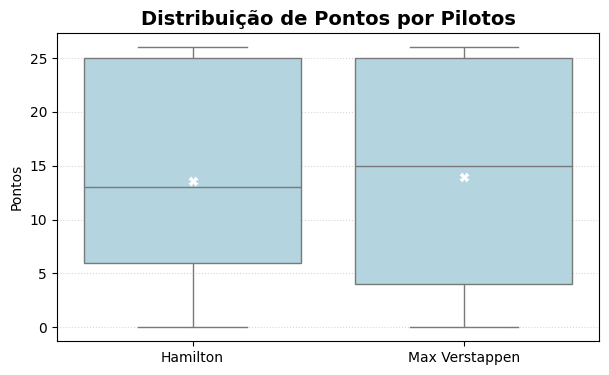

In [21]:
# Configuração do tamanho da figura

plt.figure(
    figsize=(7, 4)
    )

# Plotagem do gráfico de boxplot

sns.boxplot(
    x="Piloto",
    y="Pontos",
    data=comparativo_pilotos_df,
    hue="Piloto",

    # Definição outlier

    flierprops={
        "marker": "o",
        "color": "grey",
        "markersize": 5,
        "alpha": 0.5
    },

    # Cores dos boxplots

    palette=[
        "#ADD8E6", "#ADD8E6"
        ],

    # Denifição da média

    showmeans=True,
    meanprops={
        "marker": "X",
        "markerfacecolor": "white",
        "markeredgecolor": "none",
        "markersize": 7
        },
)

# Configuração do título e rótulos dos eixos

plt.title(
    "Distribuição de Pontos por Pilotos",
    fontsize=14,
    fontweight="bold"
    )

plt.ylabel(
    "Pontos"
    )

plt.xlabel(
    ""
)

# Adicionando grade ao gráfico

plt.grid(
    axis="y",
    linestyle=":",
    alpha=0.5)

# Exibição do gráfico

plt.show()

In [22]:
# Selecionando a coluna de pontos de cada piloto

pontos_hamilton = resultado_hamilton_df["Pontos"]
pontos_max_verstappen = resultado_max_verstappen_df["Pontos"]

# Cálculo da média de pontos para cada piloto para conclusão

media_hamilton = pontos_hamilton.mean().round(2)
media_max_verstappen = pontos_max_verstappen.mean().round(2)

# Cálculo da mediana de pontos para cada piloto para conclusão

mediana_hamilton = np.median(
    pontos_hamilton
)

mediana_max_verstappen = np.median(
    pontos_max_verstappen
)

# Conclusão tópico

print(f"Hamilton possui uma média de {media_hamilton} pontos, enquanto Max "
      f"Verstappen tem uma média de\n{media_max_verstappen} pontos.\n\n"

      "Embora os valores mínimo e máximo de ambos os pilotos sejam iguais e "
      f"não apresentem\noutliers, a mediana de Max Verstappen ("
      f"{mediana_max_verstappen}) está 2 pontos acima de Hamilton ("
      f"{mediana_hamilton}),\nindicando uma maior consistência em pontuações "
      "mais altas.\n\n"

      "Max Verstappen leva vantagem com relação à média de pontos.")

Hamilton possui uma média de 13.63 pontos, enquanto Max Verstappen tem uma média de
13.93 pontos.

Embora os valores mínimo e máximo de ambos os pilotos sejam iguais e não apresentem
outliers, a mediana de Max Verstappen (15.0) está 2 pontos acima de Hamilton (13.0),
indicando uma maior consistência em pontuações mais altas.

Max Verstappen leva vantagem com relação à média de pontos.


###4.3. Medidas de Dispersão ou Variabilidade

Avaliação da dispersão das pontuações em relação à média aritmética, com o objetivo de

compreender o grau de variabilidade dos dados. Quanto maior o valor da dispersão, maior a

dispersão dos pontos em torno da média, indicando uma maior heterogeneidade nos resultados.

In [23]:
# Cálculo do desvio padrão (populacional) de cada piloto

desvio_padrao_hamilton = np.std(
    pontos_hamilton,
    ddof=0
)

desvio_padrao_max_verstappen = np.std(
    pontos_max_verstappen,
    ddof=0
)

# Criando um DataFrame para exibir as métricas de dispersão

variabilidade_df = pd.DataFrame(
    {
    "Medida": ["Desvio Padrão"],
    "Hamilton": [desvio_padrao_hamilton],
    "Max Verstappen": [desvio_padrao_max_verstappen]
    }
)


# Definindo a primeira coluna como índice

variabilidade_df.set_index(
    "Medida",
    inplace=True
)

#  Arredondando os valores para duas casas decimais

variabilidade_df = variabilidade_df.round(2)

# Exibindo o DataFrame formatado

variabilidade_df

,Hamilton,Max Verstappen
Medida,,
Desvio Padrão,8.87,9.59


In [24]:
# Conclusão tópico

print(f"Hamilton possui um desvio padrão de {desvio_padrao_hamilton:.2f} "
      "pontos, enquanto Max Verstappen tem um\ndesvio padrão de "
      f"{desvio_padrao_max_verstappen:.2f} pontos.\n\n"

      "O desvio padrão indica o grau de dispersão dos pontos em relação à "
      "média, ou seja,\nquanto maior esse valor, maior a variação nos "
      "resultados.\n\n"

      "Os números mostram que as pontuações de Hamilton apresentam menor "
      "variação em\ncomparação às de Max Verstappen, sugerindo que suas "
      "corridas são mais regulares e\nprevisíveis.\n\n"

      "Por outro lado, a maior variação nos pontos de Max Verstappen indica "
      "que ele teve\ndesempenhos mais oscilantes, com corridas de pontuações "
      "altas, mas também baixas.\n\n"

      "Isso reforça que Hamilton mantém uma performance mais uniforme ao longo "
      "das corridas,\nrefletindo um desvio padrão menor."
     )

Hamilton possui um desvio padrão de 8.87 pontos, enquanto Max Verstappen tem um
desvio padrão de 9.59 pontos.

O desvio padrão indica o grau de dispersão dos pontos em relação à média, ou seja,
quanto maior esse valor, maior a variação nos resultados.

Os números mostram que as pontuações de Hamilton apresentam menor variação em
comparação às de Max Verstappen, sugerindo que suas corridas são mais regulares e
previsíveis.

Por outro lado, a maior variação nos pontos de Max Verstappen indica que ele teve
desempenhos mais oscilantes, com corridas de pontuações altas, mas também baixas.

Isso reforça que Hamilton mantém uma performance mais uniforme ao longo das corridas,
refletindo um desvio padrão menor.


###4.4. Série temporal

Análise detalhada para identificar se existe uma tendência consistente na evolução da média das

pontuações ao longo do tempo, considerando possíveis padrões ou variações significativas.

In [25]:
# Junção entre os DataFrames pilotos_selecionados_df e race_schedule_df para
# análise ao longo do tempo

corridas_cronograma_df = pilotos_selecionados_df.merge(
    race_schedule_df,
    on = "raceId",
    how = "left"
)

In [26]:
# Renomeando as colunas "date" para "Data" para melhor visualização

corridas_cronograma_df = corridas_cronograma_df.rename(
    columns={
        "date" : "Data"
    }
)

In [27]:
# Adicionando uma coluna que busque somente o ano do evento para trabalharmos
# posteriormente com agregação

corrida_data_df = corridas_cronograma_df.copy()
corrida_data_df["Ano_Corrida"] = corrida_data_df[
    "Data"
].str.slice(0, 4)

In [28]:
# Transformando o tipo de dado da coluna "Ano_Corrida" para int para
# trabalharmos com valores condicionais

corrida_data_df["Ano_Corrida"] = corrida_data_df["Ano_Corrida"].astype(int)

In [29]:
# Adicionando uma coluna que conste o intervalo de ano do evento para
# trabalharmos com agregação

corrida_data_df["Intervalo_Data"] = corrida_data_df["Ano_Corrida"].apply(
    lambda x:
    "2023-2024" if x >= 2023 else
    "2021-2022" if x >= 2021 else
    "2019-2020" if x >= 2019 else
    "2017-2018" if x >= 2017 else
    "2015-2016" if x >= 2015 else
    "2013-2014" if x >= 2013 else
    "2011-2012" if x >= 2011 else
    "2009-2010" if x >= 2009 else
    "2007-2008" if x >= 2007 else
    "2005-2006"
    )

In [30]:
# Seleção de colunas para plotar o gráfico

evolucao_pilotos_df = corrida_data_df[
    ["Piloto", "Intervalo_Data", "Pontos"]
].groupby(
    ["Piloto", "Intervalo_Data"]
).agg(
    {"Pontos" : "mean"}
)

# Arredondando os valores para 2 casas decimais

evolucao_pilotos_df.round(2)

Pontos
Piloto         Intervalo_Data        
hamilton       2007-2008         5.91
               2009-2010         8.03
               2011-2012        10.69
               2013-2014        14.42
               2015-2016        19.02
               2017-2018        18.80
               2019-2020        20.54
               2021-2022        14.06
               2023-2024         9.32
max_verstappen 2015-2016         6.32
               2017-2018        10.17
               2019-2020        12.95
               2021-2022        18.67
               2023-2024        22.38

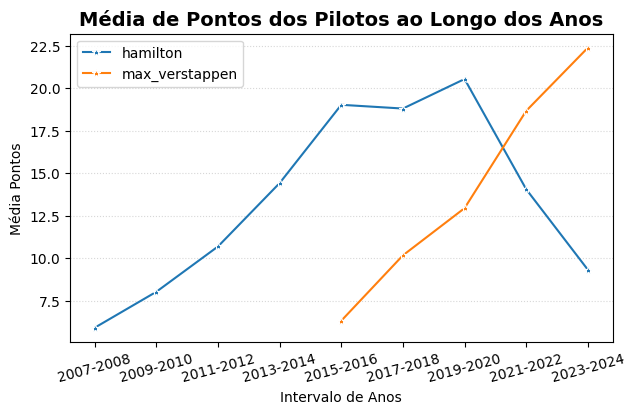

In [31]:
# Configuração do tamanho da figura

plt.figure(
    figsize=(7, 4)
)

# Criando gráfico de linhas com as três variáveis:

sns.lineplot(
    x="Intervalo_Data",
    y="Pontos",
    hue="Piloto",
    marker="*",
    data=evolucao_pilotos_df
)

# Adicionando rótulos e título

plt.xlabel(
    "Intervalo de Anos",
)

plt.ylabel(
    "Média Pontos"
)

plt.title(
    "Média de Pontos dos Pilotos ao Longo dos Anos",
    fontsize=14,
    fontweight="bold"
)

# Adicionando grade ao gráfico

plt.grid(
    axis="y",
    linestyle=":",
    alpha=0.5
)

# Rotacionar os rótulos do eixo X em 45 graus

plt.xticks(
    rotation=15
)

# Removendo apenas o título da legenda

plt.legend(title=None)

# Exibindo o gráfico

plt.show()

In [32]:
# Conclusão tópico

print(
    "Ao avaliar a evolução das corridas ao longo dos anos para os dois pilotos,"
    " percebe-se\nque ambos apresentaram crescimento na média de pontos. No "
    "entanto, Hamilton começou a\nter uma queda em sua performance a partir do "
    "período de 2019-2020.\n\n"

    "Max Verstappen se destaca no período de 2023-2024, com uma média de "
    "pontuação nunca\nantes alcançada por Hamilton.\n\n"

    "Considerando que Hamilton tem praticamente o dobro de tempo de "
    "participação na\nFórmula 1 em comparação com Max Verstappen, esperava-se "
    "que sua performance fosse\nmelhor, devido à experiência adquirida.\n\n"
)

Ao avaliar a evolução das corridas ao longo dos anos para os dois pilotos, percebe-se
que ambos apresentaram crescimento na média de pontos. No entanto, Hamilton começou a
ter uma queda em sua performance a partir do período de 2019-2020.

Max Verstappen se destaca no período de 2023-2024, com uma média de pontuação nunca
antes alcançada por Hamilton.

Considerando que Hamilton tem praticamente o dobro de tempo de participação na
Fórmula 1 em comparação com Max Verstappen, esperava-se que sua performance fosse
melhor, devido à experiência adquirida.




##5.0. Conclusão

Ao analisar as Medidas Separatrizes e de Tendência Central (tópico 4.2), observa-se que Max

Verstappen apresenta uma média de pontuação ligeiramente superior à de Hamilton. No

entanto, seu desvio padrão (tópico 4.3) também é um pouco maior, indicando uma maior

dispersão dos pontos ao redor da média, ou seja, suas pontuações variam mais entre as

corridas.

A análise de série temporal (tópico 4.4) revela uma tendência de desempenho distinta entre

os dois pilotos ao longo dos anos. Quando Max Verstappen iniciou sua trajetória na Fórmula

1 (2015-2016), Hamilton já era um competidor consolidado, com uma média de 19 pontos

por corrida, enquanto Verstappen, ainda em fase de adaptação, possuía uma média inicial de

6 pontos.

Entretanto, a evolução de Verstappen ao longo dos anos foi notável. Entre 2021 e 2022, sua

média saltou para 19 pontos, enquanto a de Hamilton caiu para 14, marcando uma inversão

na liderança do desempenho. No intervalo de 2023 e 2024, Verstappen atingiu um patamar

impressionante, superando todas as marcas previamente registradas por Hamilton e

consolidando-se como um dos pilotos mais dominantes da categoria.

Essa trajetória evidencia que Verstappen demonstrou um aprimoramento técnico e

estratégico ao longo dos anos, reforçando um desenvolvimento consistente durante as

temporadas.

Existem, obviamente, outros fatores que podem ter influenciado a queda de desempenho de

Hamilton, como o carro, as estratégias de equipe, fatores psicológicos e físicos, entre outros.

Como este estudo tem fins didáticos, não será aprofundado.